In [15]:
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import SVG, display
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
from molNet.mol.molecules import to_graph_input

from molNet.mol.polymer import Polymer, TerminalGroup, RepatingUnit

tg = TerminalGroup(Chem.MolFromSmiles("[C](C)(C)C#N"),connection_indices=[0],connection_names=["I"],name="ini")
display(tg.get_mol(with_numbers=True))

ru=RepatingUnit(Chem.MolFromSmiles("[CH2][C](C)C(=O)OC"),connection_indices=[0,1],connection_names=["A","B"],name="ru")

display(ru.get_mol(with_numbers=True))

cl=RepatingUnit(Chem.MolFromSmiles("[CH2][C](C)C(=O)OCCOC(=O)[C](C)[CH2]"),connection_indices=[0,1,11,13],connection_names=["A","B","B","A"],name="cl")

display(cl.get_mol(with_numbers=True))

In [16]:
p = Polymer()
p.starting_group = tg
p.add_repeating_unit(ru)
p.add_repeating_unit(cl, ratio=0.1)
p.mn=10**3

p.connection_map={
    "I":["A","B"],
    "A":["B"]
}

#p.get_random_mol()
g=p.get_random_graph()

%load_ext line_profiler
#print(len(g),m.nbytes)
%lprun -f p.get_random_graph p.get_random_graph()

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


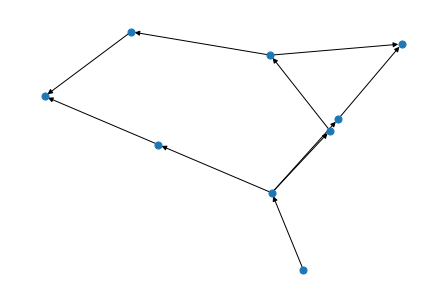

In [17]:
#nx.nx_pylab.draw_spring(g,with_labels=True,labels={i:g.nodes[i]['label'] for i in g.nodes },node_size=50)
nx.nx_pylab.draw_kamada_kawai(g,with_labels=False,labels={i:g.nodes[i]['label'] for i in g.nodes },node_size=50)

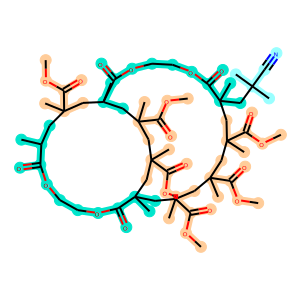

In [18]:
if len(g)<10**2:
    mol,data = p.get_random_mol(g,highlight_units=True)


    d=rdMolDraw2D.MolDraw2DSVG(300, 300)


    rdMolDraw2D.PrepareAndDrawMolecule(d,
                                       mol,
                                       highlightAtoms=data['highlight_atoms'].keys(),
                                       highlightAtomColors=data['highlight_atoms'],
                                       highlightBonds=data['highlight_bonds'].keys(),
                                       highlightBondColors=data['highlight_bonds']
                                      )
    plt.show()
    d.FinishDrawing()
    display(SVG(d.GetDrawingText()))

In [19]:
g.nodes[0]


{'unit': <molNet.mol.polymer.TerminalGroup at 0x20fc8b4cf28>,
 'label': 'ini',
 'free_conenctions': ['I']}

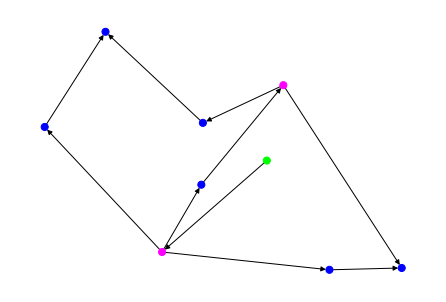

In [36]:
from molNet.featurizer.polymer import number_of_connections
g.featurize(featurizer=number_of_connections)
colors=[
    (1,0,0),
    (0,1,0),
    (0,0,1),
    (1,1,0),
    (1,0,1),
    (0,1,1),
]
for n in g.nodes:
    node = g.nodes[n]
    node["color"]=colors[node['molNet_features'][0]]

_colors = [g.nodes[n]['color'] for n in g.nodes]
nx.nx_pylab.draw(g,nx.spring_layout(g,iterations=10),
                 with_labels=False,
                               node_color=_colors,
                              labels={i:g.nodes[i]['label'] for i in g.nodes },node_size=50)

tensor([[0.9654, 0.3565, 0.7220, 0.4569, 0.3637, 0.7138, 0.1219],
        [0.2790, 0.5578, 0.7220, 0.4569, 0.3637, 0.7138, 0.1219],
        [0.8641, 0.4623, 0.8380, 0.5291, 0.2523, 0.5580, 0.4804],
        [0.6396, 0.2358, 0.6673, 0.4420, 0.9573, 0.7330, 0.8540],
        [0.2864, 0.2233, 0.8380, 0.5291, 0.2523, 0.5580, 0.4804]])